# PAE logp sampling

In [1]:

#To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
#tf.disable_eager_execution()
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import sys
import pickle
from functools import partial
import time
from tqdm import tqdm

plt.rcParams.update({'font.family' : 'lmodern', 'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5})

In [2]:
import scipy

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
tf.__version__
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
print(tf.__version__, tfp.__version__, hub.__version__)

2.2.0 0.10.0 0.8.0


### Loading the trained modules and evaluating logp in tensorflow

In [5]:
import pae.create_datasets as crd
import pae.load_data as ld
load_funcs=dict(mnist=ld.load_mnist, fmnist=ld.load_fmnist)

In [9]:

PARAMS_PATH = '/global/cscratch1/sd/vboehm/PAE_samples/FMNIST/latent_dim64/PAE/modules/'

param_file  = 'params_fmnist_-1_64_infoGAN_AE_v2rot_full_sigma'
params      = pickle.load(open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'rb'))

In [10]:
# params['module_dir']='../../modules/mnist/class-1/latent_size10/net_type_vae10/loss_AE/test_full_sigma'
# params['data_dir']= '../../data/'

In [11]:
load_func                                          = partial(load_funcs[params['data_set']])
x_train, y_train, x_valid, y_valid, x_test, y_test = load_func(params['data_dir'],flatten=False)

if np.all(x_test)==None:
    x_test=x_valid

x_train = (x_train/256.-0.5).astype(np.float32)
x_test  = (x_test/256.-0.5).astype(np.float32)
x_valid = (x_valid/256.-0.5).astype(np.float32)

In [12]:
load_func                                          = partial(load_funcs['mnist'])
x_train_ood, y_train, x_valid_ood, y_valid, x_test_ood, y_test = load_func(params['data_dir'],flatten=False)


x_train_ood = (x_train_ood/256.-0.5).astype(np.float32)
x_test_ood  = (x_test_ood/256.-0.5).astype(np.float32)
x_valid_ood = (x_valid_ood/256.-0.5).astype(np.float32)

In [13]:
params['module_dir']='/global/cscratch1/sd/vboehm/PAE_samples/FMNIST/latent_dim64/PAE/modules/'

In [14]:
generator_path   = os.path.join(params['module_dir'],'decoder')
encoder_path     = os.path.join(params['module_dir'],'encoder')
nvp_path         = os.path.join(params['module_dir'],'hybrid1_nepoch100')

In [15]:
def get_likelihood(decoder,sigma):
    sigma = tf.reshape(sigma,(params['batch_size'],-1))
    def likelihood(z):
        mean  = decoder({'z':z})['x']
        mean  = tf.reshape(mean,(params['batch_size'],-1))
        
        LL = tfd.MultivariateNormalDiag(loc=mean,scale_diag=sigma)
        return tfd.Independent(LL)

    return likelihood

def get_prior(latent_size):
    return tfd.MultivariateNormalDiag(tf.zeros(latent_size), scale_identity_multiplier=1.0)

In [16]:
#z_fill        = tf.Variable(tf.zeros((params['batch_size'],params['latent_size']),tf.float32),trainable=False)

sigma         = params['full_sigma']
sigma         = sigma.astype(np.float32)
print(sigma.shape)
encoder       = hub.KerasLayer(encoder_path,trainable=False, signature_outputs_as_dict=True)
decoder       = hub.KerasLayer(generator_path, trainable=False, signature_outputs_as_dict=True)
nvp_funcs     = hub.KerasLayer(nvp_path, trainable=False, signature_outputs_as_dict=True)

likelihood    = get_likelihood(decoder,np.repeat(np.expand_dims(sigma,0),params['batch_size'],axis=0))
prior         = get_prior(params['latent_size'])

(28, 28, 1)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [17]:
def get_encoded(x):
    mu, sigma        = tf.split(encoder({'x':x})['z'], 2, axis=-1)
    return mu

def get_decoded(z):
    return decoder({'z':z})['x']

def likelihood_eval(z,x,likelihood):
    likelihood    = likelihood(z).log_prob(x)
    return likelihood

def NF_prior_eval(z,nvp_funcs=nvp_funcs):
    prior         = nvp_funcs({'z_sample':z,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))})['log_prob']
    return prior

def posterior_eval(z,x,likelihood, nvp_funcs):
    x            = tf.reshape(x,(params['batch_size'],-1))
    likelihood   = likelihood_eval(z,x,likelihood)
    NF_prior     = NF_prior_eval(z, nvp_funcs)
    logprob      = likelihood+NF_prior
    return logprob

def Jacobian_eval(z,nvp_funcs):
    NF_prior = NF_prior_eval(z,nvp_funcs=nvp_funcs)
    J        = NF_prior-prior.log_prob(z)
    return J

In [18]:
samples_ood = []
for ii in range(1,4):
    samples_ood.append(np.load(os.path.join('/global/cscratch1/sd/vboehm/PAE_samples/FMNIST/latent_dim64/PAE/samples','HMC_MNIST_latent_dim64_burnin50_leapfrog3_%d.npy'%ii),allow_pickle=True))

In [19]:
samples_ood = np.array(samples_ood, dtype=object)
samples_ood = np.vstack(samples_ood)

In [20]:
samples = []
for ii in range(1,4):
    samples.append(np.load(os.path.join('/global/cscratch1/sd/vboehm/PAE_samples/FMNIST/latent_dim64/PAE/samples/','HMC_FMNIST_latent_dim64_burnin50_leapfrog3_%d.npy'%ii),allow_pickle=True))

In [21]:
samples = np.array(samples, dtype=object)
samples = np.vstack(samples)

In [22]:
samples_ood.shape, samples.shape

((9984, 25, 64), (9984, 25, 64))

In [23]:
posteriors_ood  = np.zeros(samples.shape[:-1])
likelihoods_ood = np.zeros(samples.shape[:-1])
Jacobians_ood   = np.zeros(samples.shape[:-1])
NF_priors_ood   = np.zeros(samples.shape[:-1])

num_chunks = len(posteriors_ood)//params['batch_size']
print(num_chunks)
for ii in range(num_chunks):
    print(ii)
    for jj in range(25):
        z  = samples_ood[ii*params['batch_size']:(ii+1)*params['batch_size'],jj]
        post = posterior_eval(z,x_test_ood[ii*params['batch_size']:(ii+1)*params['batch_size']],likelihood, nvp_funcs)
        posteriors_ood[ii*params['batch_size']:(ii+1)*params['batch_size'],jj]=post
        like = likelihood_eval(z,np.reshape(x_test_ood[ii*params['batch_size']:(ii+1)*params['batch_size']],(-1,28*28)),likelihood)
        likelihoods_ood[ii*params['batch_size']:(ii+1)*params['batch_size'],jj]=like
        jac = Jacobian_eval(z,nvp_funcs)
        Jacobians_ood[ii*params['batch_size']:(ii+1)*params['batch_size'],jj]=jac
        NFprior = NF_prior_eval(z,nvp_funcs)
        NF_priors_ood[ii*params['batch_size']:(ii+1)*params['batch_size'],jj]=NFprior   

156
0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
15

In [24]:
samples.shape

(9984, 25, 64)

In [25]:
posteriors  = np.zeros(samples.shape[:-1])
likelihoods = np.zeros(samples.shape[:-1])
Jacobians   = np.zeros(samples.shape[:-1])
NF_priors   = np.zeros(samples.shape[:-1])

num_chunks = len(posteriors)//params['batch_size']
print(num_chunks)
for ii in range(num_chunks):
    print(ii)
    for jj in range(25):
        z  = samples[ii*params['batch_size']:(ii+1)*params['batch_size'],jj]
        post = posterior_eval(z,x_test[ii*params['batch_size']:(ii+1)*params['batch_size']],likelihood, nvp_funcs)
        posteriors[ii*params['batch_size']:(ii+1)*params['batch_size'],jj]=post
        like = likelihood_eval(z,np.reshape(x_test[ii*params['batch_size']:(ii+1)*params['batch_size']],(-1,28*28)),likelihood)
        likelihoods[ii*params['batch_size']:(ii+1)*params['batch_size'],jj]=like
        jac = Jacobian_eval(z,nvp_funcs)
        Jacobians[ii*params['batch_size']:(ii+1)*params['batch_size'],jj]=jac
        NFprior = NF_prior_eval(z,nvp_funcs)
        NF_priors[ii*params['batch_size']:(ii+1)*params['batch_size'],jj]=NFprior        

156
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155


In [26]:
z_var = np.sum(np.log(np.var(samples, axis=1)),axis=-1)
z_var_ood = np.sum(np.log(np.var(samples_ood, axis=1)),axis=-1)

<ipython-input-26-1ff1ecd6d2ea>:1: RuntimeWarning: divide by zero encountered in log
  z_var = np.sum(np.log(np.var(samples, axis=1)),axis=-1)
<ipython-input-26-1ff1ecd6d2ea>:2: RuntimeWarning: divide by zero encountered in log
  z_var_ood = np.sum(np.log(np.var(samples_ood, axis=1)),axis=-1)


findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.
findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


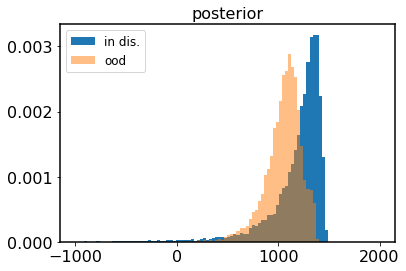

In [27]:
plt.title('posterior')
_ = plt.hist(np.mean(posteriors, axis=1),bins=100,density=True,range=(-1000,2000),label='in dis.')
_ = plt.hist(np.mean(posteriors_ood, axis=1),bins=100,density=True, alpha=0.5,range=(-1000,2000),label='ood')
plt.legend()

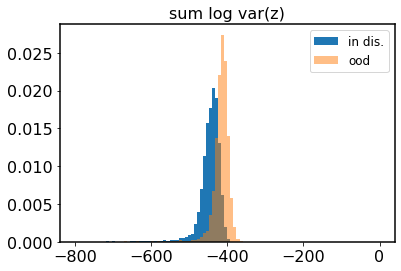

In [28]:
plt.title('sum log var(z)')
_ = plt.hist(z_var,bins=100,density=True,range=(-800,0),label='in dis.')
_ = plt.hist(z_var_ood,bins=100,density=True, alpha=0.5,range=(-800,0),label='ood')
plt.legend()

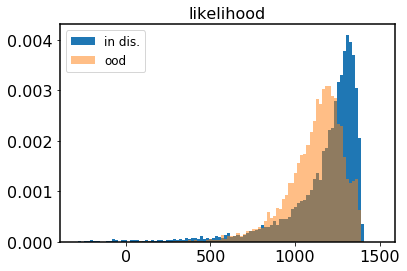

In [29]:
plt.title('likelihood')
_ = plt.hist(np.mean(likelihoods, axis=1),bins=100,density=True,range=(-300,1500),label='in dis.')
_ = plt.hist(np.mean(likelihoods_ood, axis=1),bins=100,density=True, alpha=0.5,range=(-300,1500),label='ood')
plt.legend()

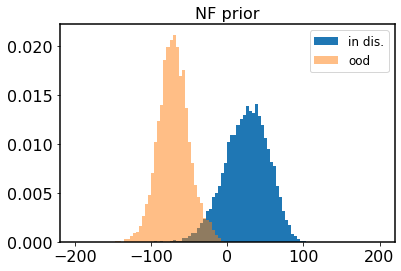

In [30]:
plt.title('NF prior')
_ = plt.hist(np.mean(NF_priors, axis=1),bins=100,density=True,range=(-200,200),label='in dis.')
_ = plt.hist(np.mean(NF_priors_ood, axis=1),bins=100,density=True, alpha=0.5,range=(-200,200),label='ood')
plt.legend()

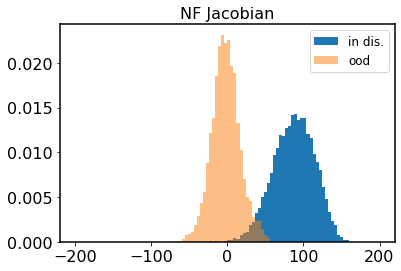

In [31]:
plt.title('NF Jacobian')
_ = plt.hist(np.mean(Jacobians, axis=1),bins=100,density=True,range=(-200,200),label='in dis.')
_ = plt.hist(np.mean(Jacobians_ood, axis=1),bins=100,density=True, alpha=0.5,range=(-200,200),label='ood')
plt.legend()